In [5]:
#importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,OrdinalEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
import warnings
warnings.simplefilter('ignore')
plt.style.use('ggplot')

In [6]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

#----------------columns to select-----------------#
column_names = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

#---------------read data----------------#
data = pd.read_csv(url, names=column_names, sep=',\s*', engine='python')

In [7]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
#--check rows of the data--#
data.shape

(32561, 15)

In [9]:
#check all null values
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

No Null values

In [10]:
# Get  statistics of numerical columns
data.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [11]:
# Check tdistribution of income (target) variable
100*data['income'].value_counts(normalize=True)

<=50K    75.919044
>50K     24.080956
Name: income, dtype: float64

It's a case of class imabalance. 

## EDA

<Axes: xlabel='age', ylabel='Density'>

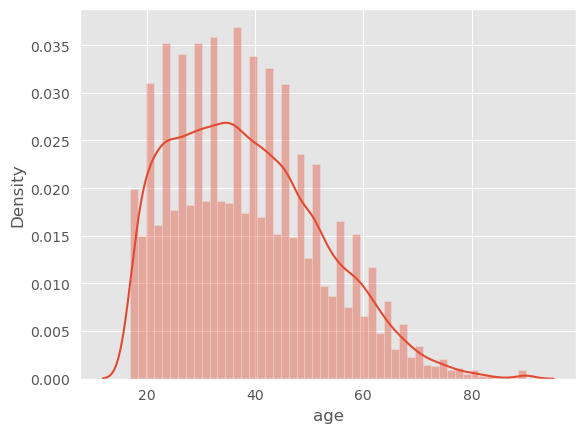

In [12]:
#----distribution of age----------#
sns.distplot(data['age'])

Most of the people belong to a age group of 20 to 60

## workclass feature

In [13]:
#distribution of workclass feature
100*data['workclass'].value_counts(normalize=True)

Private             69.703019
Self-emp-not-inc     7.803814
Local-gov            6.427935
?                    5.638647
State-gov            3.986364
Self-emp-inc         3.427413
Federal-gov          2.948312
Without-pay          0.042996
Never-worked         0.021498
Name: workclass, dtype: float64

There seem to "?" in the data. It might be due to some error. We need to replace such values with Null values.

In [14]:
#replace ? with Null values
data['workclass']=data['workclass'].replace('?',np.nan)

we have replaced "?" with NaNs lets the distribution again

In [15]:
100*data['workclass'].astype(str).value_counts(normalize=True)

Private             69.703019
Self-emp-not-inc     7.803814
Local-gov            6.427935
nan                  5.638647
State-gov            3.986364
Self-emp-inc         3.427413
Federal-gov          2.948312
Without-pay          0.042996
Never-worked         0.021498
Name: workclass, dtype: float64

We used str function to check the presence of Null. As we ca we can see the "?" has been replace by NaNs. We need to impute it or drop it? If we chose to drop we will be losing around 6% of the data or we can impute with the mode. Let's impute it.

In [16]:
#-----------------replacing Null with mode-------#
data['workclass']=data['workclass'].fillna(data['workclass'].mode()[0])

we have imputed the data let's check the distrbution again

In [17]:
100*data['workclass'].astype(str).value_counts(normalize=True)

Private             75.341666
Self-emp-not-inc     7.803814
Local-gov            6.427935
State-gov            3.986364
Self-emp-inc         3.427413
Federal-gov          2.948312
Without-pay          0.042996
Never-worked         0.021498
Name: workclass, dtype: float64

Seems perfect. However, there are few categories who contribution is less than 1% . Such distribution can create skewness in the data and will make model difficult to generalize. We can condense the categories to balance out the distribution. We can condense the categories into Private and Non-private

In [18]:
#condensing the categories  into
data['workclass']=data['workclass'].apply(lambda x:'Non-Private' if x!='Private' else x)

In [19]:
#check distribution after condensing
100*data['workclass'].astype(str).value_counts(normalize=True)

Private        75.341666
Non-Private    24.658334
Name: workclass, dtype: float64

We have condesned the workclass into Private and Non-private to reduce our skewness. 

## fnlwgt feature

<Axes: xlabel='fnlwgt', ylabel='Density'>

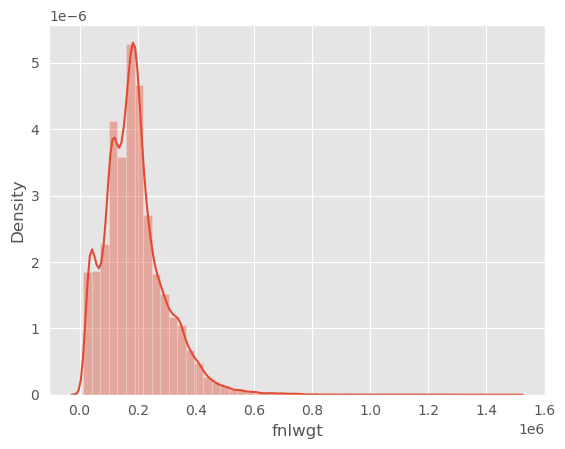

In [20]:
#fnlwgt variable. 
sns.distplot(data['fnlwgt'])

The data of this conitnuous seems a little skewed. Let's deep dive check the outliers

In [21]:
#check the stats of the feature
data['fnlwgt'].describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: fnlwgt, dtype: float64

Maximum values of the feature seems to be little out of range. Let's see how many such values are there. Let's plot the box plot

<Axes: >

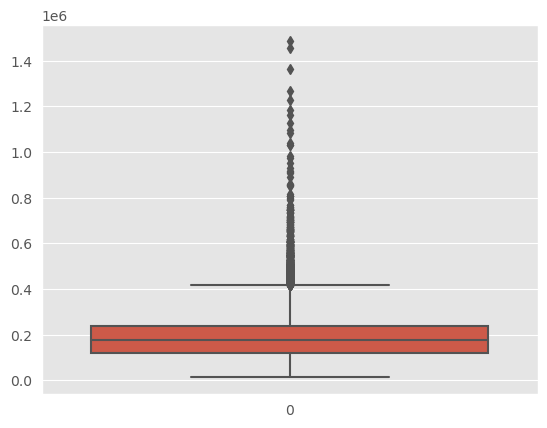

In [22]:
#----box plot----#
sns.boxplot(data['fnlwgt'])

Only one variable is lying in e+06 range. We can remove that value or we can use upto 99 percentile of feature

In [23]:
#check 99 percentile of the feature
data['fnlwgt'].quantile(0.99)

510072.0

We can use the values as we will also retain the 99% of the data. We are removing top 1% of the data

In [24]:
#---removing the max value from the feature-------#
data=data[data['fnlwgt']<=510072.0]

In [25]:
data['fnlwgt'].describe()

count     32236.00000
mean     185289.50760
std       94900.04477
min       12285.00000
25%      117500.50000
50%      177473.50000
75%      234634.75000
max      510072.00000
Name: fnlwgt, dtype: float64

Let's check the distribution now

<Axes: xlabel='fnlwgt', ylabel='Density'>

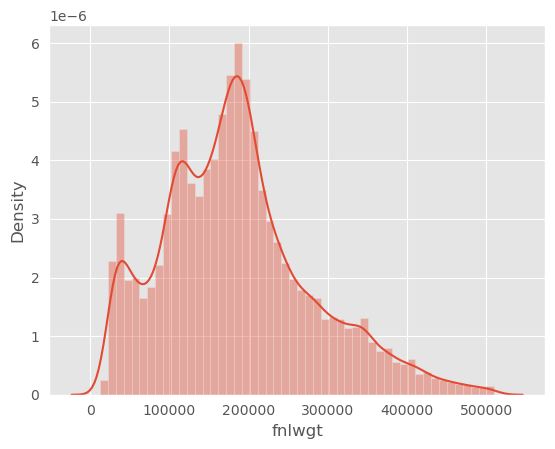

In [26]:
sns.distplot(data['fnlwgt'])

Now distribution is somewhat balanced now

## Education feature

In [27]:
#distribution of education feature
100*data['education'].value_counts(normalize=True)

HS-grad         32.249659
Some-college    22.403524
Bachelors       16.431939
Masters          5.292220
Assoc-voc        4.265418
11th             3.607768
Assoc-acdm       3.297556
10th             2.850850
7th-8th          1.988460
Prof-school      1.780618
9th              1.569674
12th             1.312198
Doctorate        1.274972
5th-6th          1.014394
1st-4th          0.508748
Preschool        0.152004
Name: education, dtype: float64

In [28]:
data['education'].value_counts(normalize=True).keys()

Index(['HS-grad', 'Some-college', 'Bachelors', 'Masters', 'Assoc-voc', '11th',
       'Assoc-acdm', '10th', '7th-8th', 'Prof-school', '9th', '12th',
       'Doctorate', '5th-6th', '1st-4th', 'Preschool'],
      dtype='object')

The distribution isn't uniform here. Few categories in the feature have even less than 5% of distribution. This won't do good for out model. Let's see if we can condense the categories. We can condense the categories having less than 5% contribution into category "other-education"

In [29]:
data['education']=data['education'].apply(lambda x:'other-education' if x in ['Assoc-voc', '11th', 'Assoc-acdm', '10th', '7th-8th', 'Prof-school', '9th', '12th',
                                                                              'Doctorate', '5th-6th', '1st-4th', 'Preschool'] else x)

In [30]:
100*data['education'].value_counts(normalize=True)

HS-grad            32.249659
other-education    23.622658
Some-college       22.403524
Bachelors          16.431939
Masters             5.292220
Name: education, dtype: float64

## Education Num

<Axes: xlabel='education-num', ylabel='Density'>

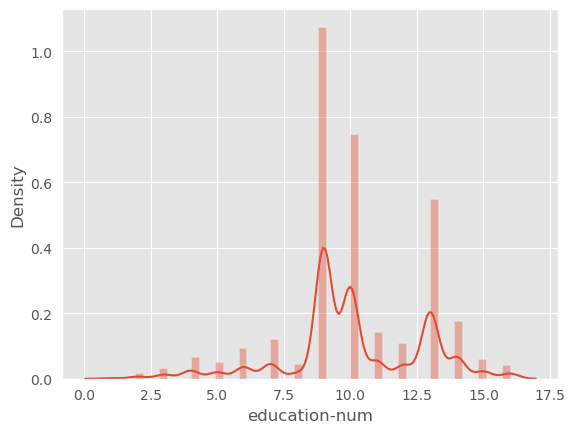

In [31]:
#distribution of the feature education-num
sns.distplot(data['education-num'])

In [32]:
#basic stats of the feature
data['education-num'].describe()

count    32236.000000
mean        10.084595
std          2.570455
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education-num, dtype: float64

The distribution seems okay and can be used as continuous variable. 

## Marital status

In [33]:
#distribution of the marital-status feature
100*data['marital-status'].value_counts(normalize=True)

Married-civ-spouse       46.032386
Never-married            32.777019
Divorced                 13.661745
Separated                 3.123837
Widowed                   3.058692
Married-spouse-absent     1.278074
Married-AF-spouse         0.068247
Name: marital-status, dtype: float64

The distribution here looks un even and we can furthure condense it to balance. We can condense it into 'Married-civ-spouse', 'Never-married', 'Divorced' and others

In [34]:
#condensing into the discussed categories
data['marital-status']=data['marital-status'].apply(lambda x:'others' if x in ['Separated',
                                                                               'Widowed', 'Married-spouse-absent', 'Married-AF-spouse'] else x)

In [35]:
100*data['marital-status'].value_counts(normalize=True)

Married-civ-spouse    46.032386
Never-married         32.777019
Divorced              13.661745
others                 7.528850
Name: marital-status, dtype: float64

Now, the distribution looks somewhat even

## Occupation

In [36]:
#distribution of occupation
100*data['occupation'].value_counts(normalize=True)

Prof-specialty       12.755925
Craft-repair         12.563593
Exec-managerial      12.504653
Adm-clerical         11.558506
Sales                11.235885
Other-service        10.112917
Machine-op-inspct     6.163916
?                     5.667577
Transport-moving      4.885842
Handlers-cleaners     4.184762
Farming-fishing       3.046284
Tech-support          2.844646
Protective-serv       1.991562
Priv-house-serv       0.456012
Armed-Forces          0.027919
Name: occupation, dtype: float64

We need to replace "?" with NaN. 

In [37]:
#replacing ? with NaN
data['occupation']=data['occupation'].replace("?",np.nan)

We need to impute NaN furthure. We can impute with Mode.

In [38]:
#replacing NaN with the mode of the feature
data['occupation']=data['occupation'].fillna(data['occupation'].mode()[0])

In [39]:
#distribution after imputation
100*data['occupation'].value_counts(normalize=True)

Prof-specialty       18.423502
Craft-repair         12.563593
Exec-managerial      12.504653
Adm-clerical         11.558506
Sales                11.235885
Other-service        10.112917
Machine-op-inspct     6.163916
Transport-moving      4.885842
Handlers-cleaners     4.184762
Farming-fishing       3.046284
Tech-support          2.844646
Protective-serv       1.991562
Priv-house-serv       0.456012
Armed-Forces          0.027919
Name: occupation, dtype: float64

We can futhure condense the category into already exieting category i.e.Other-service.

In [40]:
#condensing the categories
data['occupation']=data['occupation'].apply(lambda x:'Other-service' if x in ['Machine-op-inspct', 'Transport-moving',
                                                                              'Handlers-cleaners', 'Farming-fishing','Tech-support',
                                                                              'Protective-serv', 'Priv-house-serv', 'Armed-Forces'] else x)

In [41]:
#distrbution after condensing
100*data['occupation'].value_counts(normalize=True)

Other-service      33.713860
Prof-specialty     18.423502
Craft-repair       12.563593
Exec-managerial    12.504653
Adm-clerical       11.558506
Sales              11.235885
Name: occupation, dtype: float64

## Relationship

In [42]:
#distribution of relationship feature
100*data['relationship'].value_counts(normalize=True)

Husband           40.544733
Not-in-family     25.511850
Own-child         15.554039
Unmarried         10.559623
Wife               4.823799
Other-relative     3.005956
Name: relationship, dtype: float64

We can furthure condense the categories

In [43]:
#condensing the categories
data['relationship']=data['relationship'].apply(lambda x: 'others' if x in ['Wife',
                                                                            'Other-relative'] else x)

In [44]:
#distribution after condensing
100*data['relationship'].value_counts(normalize=True)

Husband          40.544733
Not-in-family    25.511850
Own-child        15.554039
Unmarried        10.559623
others            7.829756
Name: relationship, dtype: float64

The distribution looks better now

## race

In [45]:
#distribution of race feature
100*data['race'].value_counts(normalize=True)

White                 85.572031
Black                  9.399429
Asian-Pac-Islander     3.223105
Amer-Indian-Eskimo     0.964760
Other                  0.840675
Name: race, dtype: float64

We need to condense the categories as this is very imbalanced one and can cause overfitting issues in the model. We will condense it into two categories White and Non-white

In [46]:
#condensing the categories 
data['race']=data['race'].apply(lambda x:'Non-White' if x!='White' else x)

In [47]:
#distribution after condensing
100*data['race'].value_counts(normalize=True)

White        85.572031
Non-White    14.427969
Name: race, dtype: float64

## Sex

In [48]:
#distribution of sex feature
100*data['sex'].value_counts(normalize=True)

Male      66.891053
Female    33.108947
Name: sex, dtype: float64

The distribution looks fine

## native country

In [49]:
#distribution of native-country feature
100*data['native-country'].value_counts(normalize=True)

United-States                 89.654424
Mexico                         1.923316
?                              1.786822
Philippines                    0.611118
Germany                        0.421889
Canada                         0.375357
Puerto-Rico                    0.347438
India                          0.310212
El-Salvador                    0.307110
Cuba                           0.294702
England                        0.279191
Jamaica                        0.251272
South                          0.248170
China                          0.232659
Italy                          0.223353
Dominican-Republic             0.217149
Vietnam                        0.207842
Guatemala                      0.189229
Japan                          0.186127
Poland                         0.186127
Columbia                       0.176821
Taiwan                         0.158208
Haiti                          0.136493
Iran                           0.133391
Portugal                       0.114779


Most of the people in th data belong to US. We can condense the category into US and other-country. We also have "?" in the data. We need to replace the value with NaN and impute it.

In [50]:
#replacing ? with NaN
data['native-country']=data['native-country'].replace("?",np.nan)

#imputing Null with mode of the feature
data['native-country']=data['native-country'].fillna(data['native-country'].mode()[0])

In [51]:
#distribution after imputation
100*data['native-country'].value_counts(normalize=True)

United-States                 91.441246
Mexico                         1.923316
Philippines                    0.611118
Germany                        0.421889
Canada                         0.375357
Puerto-Rico                    0.347438
India                          0.310212
El-Salvador                    0.307110
Cuba                           0.294702
England                        0.279191
Jamaica                        0.251272
South                          0.248170
China                          0.232659
Italy                          0.223353
Dominican-Republic             0.217149
Vietnam                        0.207842
Guatemala                      0.189229
Japan                          0.186127
Poland                         0.186127
Columbia                       0.176821
Taiwan                         0.158208
Haiti                          0.136493
Iran                           0.133391
Portugal                       0.114779
Peru                           0.093064


In [52]:
#condense the category into us and other-country
data['native-country']=data['native-country'].apply(lambda x:'other-countries' if x!='United-States' else x)

In [53]:
#distribution after condensing
100*data['native-country'].value_counts(normalize=True)

United-States      91.441246
other-countries     8.558754
Name: native-country, dtype: float64

The distribution looks great now. But since this feature has 91% people from US only this will create imabalance problem in data and we won't be considering this feature for our model building as the distribution is highly skewed

In [54]:
#drop native country column
data.drop('native-country',axis=1,inplace=True)

## hours per week

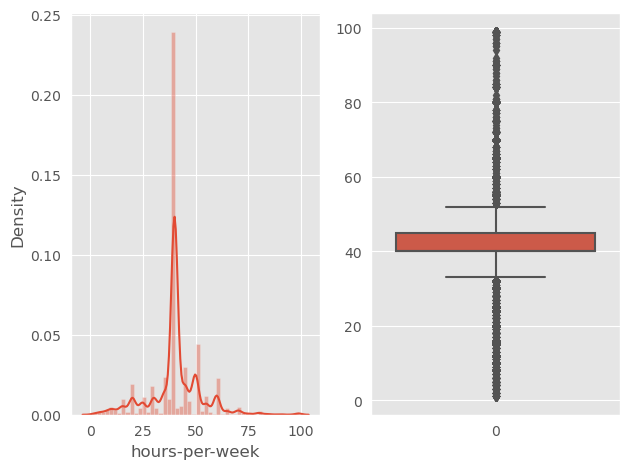

In [55]:
#plot distribution and box plots
fig,ax=plt.subplots(1,2)
sns.distplot(data['hours-per-week'],ax=ax[0])
sns.boxplot(data['hours-per-week'],ax=ax[1])
plt.tight_layout()

The distribution looks closer to gaussian. Let's see if we have any outliers

In [56]:
data['hours-per-week'].describe()

count    32236.000000
mean        40.442921
std         12.355288
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours-per-week, dtype: float64

Distribution looks good and we are good to go

In [57]:
#Dropping capital-gain capital-loss as most of the values are zero.
data.drop(['capital-gain','capital-loss'],axis=1,inplace=True)

## Preprocessing

**In this section we will do preprocessing of the data. We will first split the data into train and test. We will use 80-20 split**

In [58]:
#lets encode target variable to 0 and 1
data['income']=data['income'].map({'<=50K':0,">50K":1})

In [59]:
#declare dependent and independent variables
X=data.drop('income',axis=1)
y=data['income']

In [60]:
#split the data into train and test
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

In [61]:
x_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week
5381,26,Private,58065,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Female,20
17182,57,Private,206343,HS-grad,9,others,Other-service,Not-in-family,White,Male,40
16517,31,Private,198069,HS-grad,9,Never-married,Other-service,Own-child,White,Male,24
2117,45,Non-Private,135776,Masters,14,Divorced,Prof-specialty,Not-in-family,White,Female,30
2579,47,Private,188330,HS-grad,9,Married-civ-spouse,Other-service,Husband,White,Male,25


We will ordinal encode the education variable and th rest categorical variable will be encoded as One-hot

In [62]:
#ordinal encodng of education feature
ordinal=OrdinalEncoder(categories=[['other-education', 'Some-college','HS-grad','Bachelors','Masters']])
x_train['education']=ordinal.fit_transform(x_train[['education']])
x_test['education']=ordinal.transform(x_test[['education']])

In [63]:
x_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week
5381,26,Private,58065,3.0,13,Never-married,Adm-clerical,Not-in-family,White,Female,20
17182,57,Private,206343,2.0,9,others,Other-service,Not-in-family,White,Male,40
16517,31,Private,198069,2.0,9,Never-married,Other-service,Own-child,White,Male,24
2117,45,Non-Private,135776,4.0,14,Divorced,Prof-specialty,Not-in-family,White,Female,30
2579,47,Private,188330,2.0,9,Married-civ-spouse,Other-service,Husband,White,Male,25


We can do label encoding for private class they are only two categoris

In [64]:
#converting working class and sex feature into binary
label=LabelEncoder()
cat=['workclass','sex']
for i in cat:
    x_train[i]=label.fit_transform(x_train[i])
    x_test[i]=label.transform(x_test[i])

In [65]:
x_train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week
5381,26,1,58065,3.0,13,Never-married,Adm-clerical,Not-in-family,White,0,20
17182,57,1,206343,2.0,9,others,Other-service,Not-in-family,White,1,40
16517,31,1,198069,2.0,9,Never-married,Other-service,Own-child,White,1,24
2117,45,0,135776,4.0,14,Divorced,Prof-specialty,Not-in-family,White,0,30
2579,47,1,188330,2.0,9,Married-civ-spouse,Other-service,Husband,White,1,25


One-Hot encoding the rest of the categorical columns

In [66]:
#categorical and numerical columns
cat_cols=['marital-status','occupation','relationship','race']
num_cols=['age','fnlwgt','education','education-num','hours-per-week']

In [67]:
#create a columns Transformer
ct=ColumnTransformer([
    ('On-hot-encode',OneHotEncoder(handle_unknown='ignore'),cat_cols),
    ('scaling',MinMaxScaler(),num_cols)
])

## Logistic Regression

In [68]:
#create a Pipeline and build a model
pipeline=Pipeline([
    ('ct',ct),
    ('model',LogisticRegression())
])

In [69]:
pipeline.fit(x_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('On-hot-encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['marital-status',
                                                   'occupation', 'relationship',
                                                   'race']),
                                                 ('scaling', MinMaxScaler(),
                                                  ['age', 'fnlwgt', 'education',
                                                   'education-num',
                                                   'hours-per-week'])])),
                ('model', LogisticRegression())])

In [70]:
#create a function to evaluate model
def evaluate(model,data,y_true):
    """
    :param model: trained model
    :param data: test data
    :param y_true: actual y
    :return: accuracy,classification_report and confusion matrix
    """
    y_pred=model.predict(data)
    accuracy=accuracy_score(y_true,y_pred)
    report=classification_report(y_true,y_pred)
    cnf_matrix=confusion_matrix(y_true,y_pred)
    #train accuracy
    print('-----------o-------------')
    print('Accuracy:',accuracy*100)
    print('------------o------------')
    print('Classfication report:\n', report)
    print('------------o------------')
    print('Logistic regression Confusion Matrix:\n',cnf_matrix)
    print('----------------o--------------')

As this is a class imbalance problem. We should look at the f1-score for better understanding.

In [71]:
#training score
evaluate(pipeline,x_train,y_train)

-----------o-------------
Accuracy: 82.76330076004344
------------o------------
Classfication report:
               precision    recall  f1-score   support

           0       0.86      0.92      0.89     19575
           1       0.69      0.52      0.59      6213

    accuracy                           0.83     25788
   macro avg       0.77      0.72      0.74     25788
weighted avg       0.82      0.83      0.82     25788

------------o------------
Logistic regression Confusion Matrix:
 [[18105  1470]
 [ 2975  3238]]
----------------o--------------


In [72]:
#testing scores
evaluate(pipeline,x_test,y_test)

-----------o-------------
Accuracy: 81.94789081885855
------------o------------
Classfication report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      4894
           1       0.66      0.52      0.58      1554

    accuracy                           0.82      6448
   macro avg       0.76      0.72      0.73      6448
weighted avg       0.81      0.82      0.81      6448

------------o------------
Logistic regression Confusion Matrix:
 [[4471  423]
 [ 741  813]]
----------------o--------------


* We can also see that model isn't overfitting. This is a case of Class imabalnce problem , so we need to adjust the weights of our class

In [73]:
#create a Pipeline and build a model
pipeline_wt_balance=Pipeline([
    ('ct',ct),
    ('model',LogisticRegression(class_weight={0:1,1:1.5}))
])
pipeline_wt_balance.fit(x_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('On-hot-encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['marital-status',
                                                   'occupation', 'relationship',
                                                   'race']),
                                                 ('scaling', MinMaxScaler(),
                                                  ['age', 'fnlwgt', 'education',
                                                   'education-num',
                                                   'hours-per-week'])])),
                ('model', LogisticRegression(class_weight={0: 1, 1: 1.5}))])

In [74]:
#training score
evaluate(pipeline_wt_balance,x_train,y_train)

-----------o-------------
Accuracy: 82.37164572669458
------------o------------
Classfication report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88     19575
           1       0.63      0.64      0.64      6213

    accuracy                           0.82     25788
   macro avg       0.76      0.76      0.76     25788
weighted avg       0.82      0.82      0.82     25788

------------o------------
Logistic regression Confusion Matrix:
 [[17262  2313]
 [ 2233  3980]]
----------------o--------------


In [75]:
#test score
evaluate(pipeline_wt_balance,x_test,y_test)

-----------o-------------
Accuracy: 81.42059553349877
------------o------------
Classfication report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88      4894
           1       0.61      0.64      0.63      1554

    accuracy                           0.81      6448
   macro avg       0.75      0.76      0.75      6448
weighted avg       0.82      0.81      0.82      6448

------------o------------
Logistic regression Confusion Matrix:
 [[4249  645]
 [ 553 1001]]
----------------o--------------


*Adjusting our weights has improved the f1-score.*

## XGBoost

In [76]:
#create a Pipeline and build a xgboost
pipeline_xgb=Pipeline([
    ('ct',ct),
    ('model',XGBClassifier(n_estimators=100,max_depth=2,class_wieght={0:1,1:1.5}))
])
pipeline_xgb.fit(x_train,y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('On-hot-encode',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['marital-status',
                                                   'occupation', 'relationship',
                                                   'race']),
                                                 ('scaling', MinMaxScaler(),
                                                  ['age', 'fnlwgt', 'education',
                                                   'education-num',
                                                   'hours-per-week'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               class_wieght={0: 1, 1: 1.5},
                               c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [77]:
evaluate(pipeline_xgb,x_train,y_train)

-----------o-------------
Accuracy: 84.07786567395688
------------o------------
Classfication report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90     19575
           1       0.72      0.56      0.63      6213

    accuracy                           0.84     25788
   macro avg       0.79      0.75      0.76     25788
weighted avg       0.83      0.84      0.83     25788

------------o------------
Logistic regression Confusion Matrix:
 [[18180  1395]
 [ 2711  3502]]
----------------o--------------


In [78]:
#testing score
evaluate(pipeline_xgb,x_test,y_test)

-----------o-------------
Accuracy: 83.00248138957816
------------o------------
Classfication report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      4894
           1       0.68      0.56      0.61      1554

    accuracy                           0.83      6448
   macro avg       0.77      0.74      0.75      6448
weighted avg       0.82      0.83      0.82      6448

------------o------------
Logistic regression Confusion Matrix:
 [[4489  405]
 [ 691  863]]
----------------o--------------


## Roc-Auc Curve

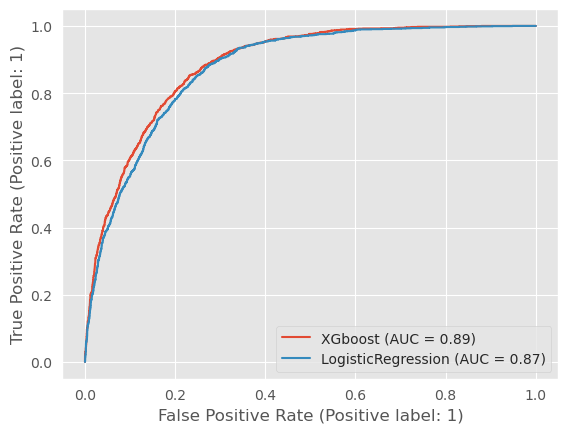

In [82]:
#plot roc-auc curve for both the model
disp=RocCurveDisplay.from_estimator(pipeline_xgb,x_test,y_test,name='XGboost')
RocCurveDisplay.from_estimator(pipeline_wt_balance,x_test,y_test,ax=disp.ax_,name='LogisticRegression')

* From the above we can see that AUC is higher for XGboost model. We should chose this model as this is giving better generalization than logistic model.

**Business Problem**
The business problem we are trying to solve is predicting whether an individual's income exceeds $50K per year based on census data. We built two models in our analyis LogisticRegression and XGboost

* LogisticRegression has given a reasonable performance based on its AUC score
* XGboost is a boosting (ensemble) technique which performs generally better than other machine learning algorithms. The model has shown better performance in terms f1-score, auc score. 